# Read DWD Time Series for Recent Annual Temperature, Merge with Station Description and Append 

  * Temperature at climate stations in **NRW** only
  * **Annual mean temperature** data from the **recent** data set
  * Time interval **from xxx to yyy**  


## DWD Subdirectory, Topic of Interest: annual - KL - recent!

The annual mean temperatures have to be used for analysis. "recent" is used because the data set comprises just values of the last five years. This is enough for this exercise.

In [1]:
# The topic of interest
topic_dir = "/annual/kl/recent/"
print("Subdirectory on FTP Server:", topic_dir)

Subdirectory on FTP Server: /annual/kl/recent/


## Local Directories

In [2]:
#local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

#local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [3]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//annual/kl/recent/
data/original/DWD//annual/kl/recent/

data/generated/DWD/
data/generated/DWD//annual/kl/recent/
data/generated/DWD//annual/kl/recent/
data/generated/DWD//annual/kl/recent/


## FTP Connection

### Connection Parameters

In [5]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [6]:
# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"

# The absolute ftp directory with the data (topic) of concern
ftp_dir =  ftp_climate_data_dir + topic_dir
print("Absolte FTP directory path with data of concern:", ftp_dir)

Absolte FTP directory path with data of concern: /climate_environment/CDC/observations_germany/climate//annual/kl/recent/


### FTP Connect

In [7]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [9]:
ret = ftp.cwd(".")

In [10]:
#ftp.quit()

### FTP Grab File Function

In [11]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



## Generate Pandas Dataframe from FTP Directory Listing

In [12]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [13]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [14]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,KL_Jahreswerte_Beschreibung_Stationen.txt,.txt,239581,-
1,44,jahreswerte_KL_00044_akt.zip,.zip,14873,-
2,71,jahreswerte_KL_00071_akt.zip,.zip,14134,-
3,73,jahreswerte_KL_00073_akt.zip,.zip,15753,-
4,78,jahreswerte_KL_00078_akt.zip,.zip,11670,-
5,91,jahreswerte_KL_00091_akt.zip,.zip,11754,-
6,96,jahreswerte_KL_00096_akt.zip,.zip,13266,-
7,102,jahreswerte_KL_00102_akt.zip,.zip,11808,-
8,125,jahreswerte_KL_00125_akt.zip,.zip,4693,-
9,131,jahreswerte_KL_00131_akt.zip,.zip,12688,-


### Dataframe with TS Zip Files

In [15]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
44,jahreswerte_KL_00044_akt.zip,.zip,14873,-
71,jahreswerte_KL_00071_akt.zip,.zip,14134,-
73,jahreswerte_KL_00073_akt.zip,.zip,15753,-
78,jahreswerte_KL_00078_akt.zip,.zip,11670,-
91,jahreswerte_KL_00091_akt.zip,.zip,11754,-
96,jahreswerte_KL_00096_akt.zip,.zip,13266,-
102,jahreswerte_KL_00102_akt.zip,.zip,11808,-
125,jahreswerte_KL_00125_akt.zip,.zip,4693,-
131,jahreswerte_KL_00131_akt.zip,.zip,12688,-


## Download the Station Description File

In [16]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

KL_Jahreswerte_Beschreibung_Stationen.txt


In [17]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//annual/kl/recent/KL_Jahreswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//annual/kl/recent/KL_Jahreswerte_Beschreibung_Stationen.txt


In [18]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile, "r", encoding="latin1")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(\
        txtfile, skiprows=2, names=colnames_en, \
        parse_dates=["date_from","date_to"], index_col = 0, \
        encoding="latin1")
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [19]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1931-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1851-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,1971-03-01,2022-12-31,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,1973-01-01,2001-12-31,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
61,1975-07-01,1978-08-31,339,48.8443,12.6171,Aiterhofen,Bayern


### Select Stations Located in NRW from Station Description Dataframe

In [20]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = (df_stations['state'] == "Nordrhein-Westfalen").values

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isActive2021 = (df_stations['date_to'] > "2021").values 

# select on both conditions
station_ids_selected = df_stations[isNRW & isActive2021].index

print(f"Stations located in NRW and still active in 2021: \n{list(station_ids_selected)}")


Stations located in NRW and still active in 2021: 
[390, 555, 603, 617, 1078, 1246, 1300, 1303, 1327, 1590, 1766, 2110, 2483, 2497, 2629, 2667, 2947, 2968, 3028, 3031, 3098, 3540, 3591, 3623, 4063, 4127, 4371, 5064, 5347, 5480, 5717, 6197, 6264, 6337, 7106, 7330, 7374, 13670, 13696, 13700, 13713, 15000]


In [ ]:
df_stations.loc[station_ids_selected].head()

## Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [21]:
# Add the names of the zip files only to a list. 
local_zip_list = []

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

jahreswerte_KL_00390_akt.zip
jahreswerte_KL_00555_akt.zip
jahreswerte_KL_00603_akt.zip
jahreswerte_KL_00617_akt.zip
jahreswerte_KL_01078_akt.zip
jahreswerte_KL_01246_akt.zip
jahreswerte_KL_01300_akt.zip
jahreswerte_KL_01303_akt.zip
jahreswerte_KL_01327_akt.zip
jahreswerte_KL_01590_akt.zip
jahreswerte_KL_01766_akt.zip
jahreswerte_KL_02110_akt.zip
jahreswerte_KL_02483_akt.zip
jahreswerte_KL_02497_akt.zip
jahreswerte_KL_02629_akt.zip
jahreswerte_KL_02667_akt.zip
jahreswerte_KL_02947_akt.zip
jahreswerte_KL_02968_akt.zip
jahreswerte_KL_03028_akt.zip
jahreswerte_KL_03031_akt.zip
jahreswerte_KL_03098_akt.zip
jahreswerte_KL_03540_akt.zip
jahreswerte_KL_03591_akt.zip
jahreswerte_KL_03623_akt.zip
jahreswerte_KL_04063_akt.zip
jahreswerte_KL_04127_akt.zip
jahreswerte_KL_04371_akt.zip
jahreswerte_KL_05064_akt.zip
jahreswerte_KL_05347_akt.zip
jahreswerte_KL_05480_akt.zip
jahreswerte_KL_05717_akt.zip
jahreswerte_KL_06197_akt.zip
jahreswerte_KL_06264_akt.zip
jahreswerte_KL_06337_akt.zip
jahreswerte_KL

## Selected Period for Time Series in Data Frames

These parameters are used to limit the time period of the series added to the Pandas data frames. 
<br>To select all dates in the series you can set a very broad interval, e.g.

```python
date_from = '1700-01-01'
date_to   = '2100-12-31'
```

In [22]:
#date_from = '2019-05-01'
#date_to   = '2019-05-31'
date_from = '1700-01-01'
date_to   = '2100-12-31'

## Join (Merge) the Time Series Columns

The goal is to create a data frame with column oriented time series. Each column contuins a time series for one station. Column name is the station number.

More on merge and join: <br>
https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd



### Precipitation Time Series Data (text file) to Data Frame 
Read a text file with precipitation time series (CSV file) and make it a data frame. <br>
Only add measuerments which lie within the given time period.

In [23]:
import datetime as dt

In [24]:
def prec_ts_to_df(fname, date_from='1700-01-01', date_to='2100-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index >= date_from) & (df.index <= date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

### Climate Time Series Data (text file) to Data Frame 
The KL data format for annual temperatures differs significantly from the RR format for hourly precipitation.

Tha annual data uses an interval `[MESS_DATUM_BEGINN, MESS_DATUM_ENDE]`, e.g. ['20180101','20181231'], as time reference for the measurements whereas the hourly data provides a unique time stamp in hourly resolution, e.g. '2018052113'.

In [25]:
def kl_ts_to_df(fname, date_from='1700-01-01', date_to='2100-12-31'):
    import datetime as dt
    
    dateparse = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], date_parser = dateparse, na_values = [-999.0, -999])

    # Attention: Selecting df with given dates may lead to empty result!
    df = df[(df.index >= date_from) & (df.index <= date_to)]
    
    # Code inspired by: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

### Merge Columnwise

In [26]:
from zipfile import ZipFile
def ts_merge(date_from='1700-01-01', date_to='2100-12-31'):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = kl_ts_to_df(myfile, date_from, date_to)

                if len(dftmp) > 0: # Check if cropped df is empty, i.e. no values in given period.
                    s = dftmp["ja_tt"].rename(dftmp["stations_id"][0]).to_frame()
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')
                else:
                    print("WARNING: data file", prodfilename, "does not contain data for given period.")

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [27]:
# df_merged_ts = ts_merge(date_from, date_to)
df_merged_ts = ts_merge(date_from, date_to)

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00390_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_00390.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00555_akt.zip
Extract product file: produkt_klima_jahr_20170101_20211231_00555.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00603_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_00603.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00617_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_00617.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01078_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01078.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01246_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01246.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01300_akt.zip
Extract product file: produkt_klim

In [28]:
print('df_merged_ts.shape:', df_merged_ts.shape)
df_merged_ts.head()

df_merged_ts.shape: (6, 42)


,390,555,603,617,1078,1246,1300,1303,1327,1590,...,6264,6337,7106,7330,7374,13670,13696,13700,13713,15000
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,10.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,8.59,NaN,11.60,11.57,12.12,11.39,9.24,11.79,11.60,11.86,...,9.66,11.47,10.73,10.48,11.32,12.36,11.40,11.11,9.79,11.21
2019-01-01,8.31,NaN,11.30,11.31,11.84,11.17,9.00,11.44,11.24,11.62,...,9.42,11.18,10.64,10.34,11.04,12.02,11.16,10.87,9.33,10.85
2020-01-01,8.57,NaN,11.86,11.64,12.25,11.43,9.44,11.84,11.81,12.18,...,9.65,11.53,10.92,10.70,11.35,12.41,11.57,11.23,9.86,11.42
2021-01-01,7.20,NaN,10.48,10.40,10.78,10.16,8.14,10.42,10.37,10.67,...,8.26,10.19,9.80,9.50,10.16,10.98,10.33,9.84,8.56,10.02


In [29]:
df_merged_ts.to_csv(local_ts_merged_dir + "ts_merged.csv",sep=";")

## Plotting a few Data Series for a first Check

Plot for example the Series of Stations Essen-Bredeney, Düsseldorf, and Kahler Asten


In [30]:
df_plt = df_stations[ ( ( df_stations['name'].str.contains("Essen-Bre") ) | (df_stations['name'].str.contains("Düssel") | ( df_stations['name'].str.contains("Kahler") ) ) ) & (df_stations['date_to'] > '2019') ]
df_plt

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1078,1940-01-01,2022-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1303,1888-01-01,2022-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
2483,1926-11-01,2022-12-31,839,51.1803,8.4891,Kahler Asten,Nordrhein-Westfalen


In [31]:
idx = list(df_plt.index)
#idx = [1078,1303]
print("Station_ID to be plotted:", idx)

Station_ID to be plotted: [1078, 1303, 2483]


In [32]:
df_merged_ts[idx].head()

,1078,1303,2483
time,,,
2017-01-01,NaN,NaN,NaN
2018-01-01,12.12,11.79,7.26
2019-01-01,11.84,11.44,7.00
2020-01-01,12.25,11.84,7.28
2021-01-01,10.78,10.42,5.85


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

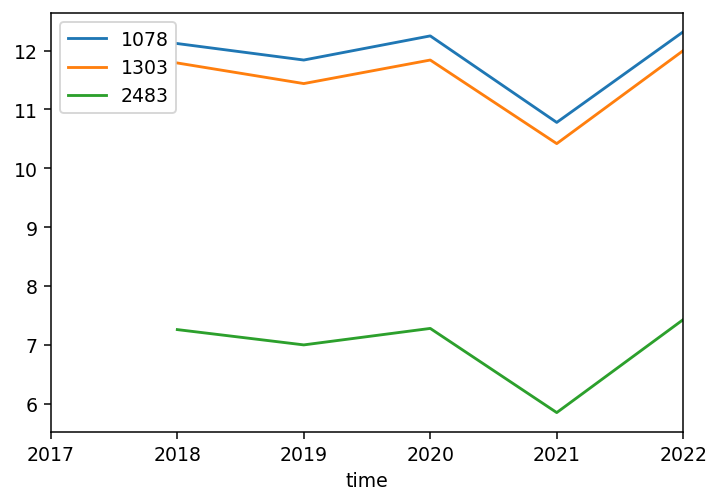

In [34]:
fig1, ax1 = plt.subplots(dpi=136, figsize=(6,4))
df_merged_ts[idx].plot(ax=ax1)
#ax1.set_xlim(pd.Timestamp('2019-05-01'), pd.Timestamp('2019-05-30'))
plt.show()

## Append Time Series 

Append the time series one below the other. The station number is added as an additional column to identify the time series. 

This format is necessary for the **QGIS Time Manager**.

In [35]:
def ts_append(date_from='1700-01-01', date_to='2100-12-31'):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = kl_ts_to_df(myfile, date_from, date_to)

                if len(dftmp) > 0: # Check if cropped df is empty, i.e. no values in given period.
                    dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
                    df = df.append(dftmp)
                else:
                    print("WARNING: data file", prodfilename, "does not contain data for given period.")
                
    df.index.rename(name = "time", inplace = True)
    return(df)

In [36]:
df_appended_ts = ts_append(date_from, date_to)

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00390_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_00390.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00555_akt.zip
Extract product file: produkt_klima_jahr_20170101_20211231_00555.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00603_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_00603.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_00617_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_00617.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01078_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01078.txt



C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append metho

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01246_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01246.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01300_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01300.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01303_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01303.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01327_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01327.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01590_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01590.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_01766_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_01766.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_02110_akt.zip
Extract product file: produkt_klim

C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append metho

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_02497_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_02497.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_02629_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_02629.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_02667_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_02667.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_02947_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_02947.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_02968_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_02968.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_03028_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_03028.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_03031_akt.zip
Extract product file: produkt_klim

C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append metho

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_03623_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_03623.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_04063_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_04063.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_04127_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_04127.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_04371_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_04371.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_05064_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_05064.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_05347_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_05347.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_05480_akt.zip
Extract product file: produkt_klim

C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append metho

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_06337_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_06337.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_07106_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_07106.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_07330_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_07330.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_07374_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_07374.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_13670_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_13670.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_13696_akt.zip
Extract product file: produkt_klima_jahr_20180101_20221231_13696.txt

Zip archive: data/original/DWD//annual/kl/recent/jahreswerte_KL_13700_akt.zip
Extract product file: produkt_klim

C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)
C:\Users\User\AppData\Local\Temp\ipykernel_11136\1600009885.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dftmp)


In [37]:
df_appended_ts.head(20)

,stations_id,mess_datum_ende,qn_4,ja_n,ja_tt,ja_tx,ja_tn,ja_fk,ja_sd_s,ja_mx_fx,...,ja_rr,ja_mx_rs,eor,date_from,date_to,altitude,latitude,longitude,name,state
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,390,2018-12-31,10.0,-999.00,8.59,12.80,4.65,NaN,NaN,NaN,...,796.7,33.4,eor,1986-12-01,2022-12-31,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
2019-01-01,390,2019-12-31,10.0,-999.00,8.31,12.29,4.49,NaN,NaN,NaN,...,1083.2,43.9,eor,1986-12-01,2022-12-31,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
2020-01-01,390,2020-12-31,10.0,-999.00,8.57,12.56,4.68,NaN,NaN,NaN,...,982.7,29.8,eor,1986-12-01,2022-12-31,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
2021-01-01,390,2021-12-31,3.0,-999.00,7.20,11.01,3.76,NaN,NaN,NaN,...,835.2,23.0,eor,1986-12-01,2022-12-31,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
2022-01-01,390,2022-12-31,1.0,-999.00,8.82,13.03,4.78,NaN,NaN,NaN,...,981.5,37.5,eor,1986-12-01,2022-12-31,610,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen
2017-01-01,555,2017-12-31,10.0,-999.00,10.91,15.07,6.50,NaN,1427.60,NaN,...,876.4,37.2,eor,1925-01-01,2023-02-28,110,51.5026,7.2289,Bochum,Nordrhein-Westfalen
2018-01-01,603,2018-12-31,9.0,-999.00,11.60,16.39,6.82,NaN,2013.90,NaN,...,617.6,36.5,eor,2000-07-04,2022-12-31,147,50.7293,7.2040,Königswinter-Heiderhof,Nordrhein-Westfalen
2019-01-01,603,2019-12-31,9.0,-999.00,11.30,16.00,6.71,NaN,NaN,NaN,...,NaN,NaN,eor,2000-07-04,2022-12-31,147,50.7293,7.2040,Königswinter-Heiderhof,Nordrhein-Westfalen
2020-01-01,603,2020-12-31,9.0,-999.00,11.86,16.43,6.86,NaN,NaN,NaN,...,581.9,NaN,eor,2000-07-04,2022-12-31,147,50.7293,7.2040,Königswinter-Heiderhof,Nordrhein-Westfalen


In [38]:
df_appended_ts.to_csv(local_ts_appended_dir + "ts_appended.csv",sep=";")

## Plot Temperature vs. Altitude

In [39]:
df_plot = df_appended_ts[ (df_appended_ts.index == '2021-01-01') & (df_appended_ts['state'].str.contains("Nordrhein"))  ]
print("df_plot.shape:", df_plot.shape)

df_plot.shape: (40, 23)


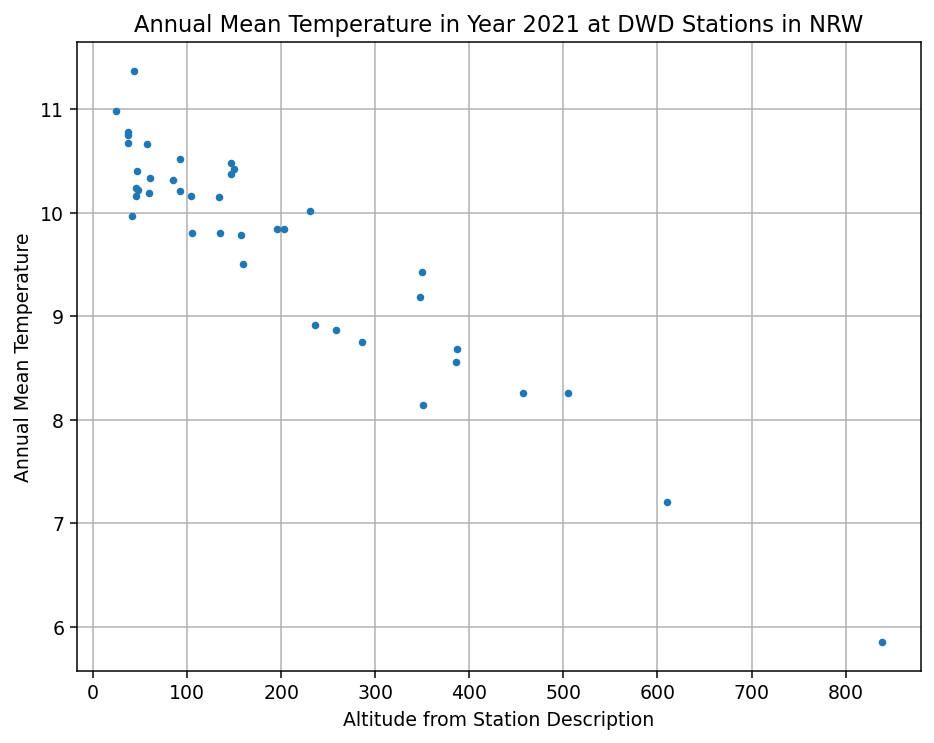

In [40]:
fig2, ax2 = plt.subplots(dpi=136, figsize=(8,6))
#df_appended_ts[idx].plot(ax=ax1)
ax2.plot(df_plot['altitude'],df_plot['ja_tt'],".")
#ax1.set_xlim(pd.Timestamp('2019-05-01'), pd.Timestamp('2019-05-30'))
#ax2.set_ylim(4,14)
ax2.set_ylabel("Annual Mean Temperature")
ax2.set_xlabel("Altitude from Station Description")
ax2.set_title("Annual Mean Temperature in Year 2021 at DWD Stations in NRW")
ax2.grid(True)
plt.show()

In [41]:
fig2.savefig("fig1.png")

## Data from Zugspitze, just for curiosity ...

In [42]:
df_stations[df_stations['name'].str.contains("Zug")]

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
5792,1900-08-01,2022-12-31,956,47.421,10.9848,Zugspitze,Bayern


In [43]:
df_appended_ts[df_appended_ts['name'].str.contains("Zug")]

,stations_id,mess_datum_ende,qn_4,ja_n,ja_tt,ja_tx,ja_tn,ja_fk,ja_sd_s,ja_mx_fx,...,ja_rr,ja_mx_rs,eor,date_from,date_to,altitude,latitude,longitude,name,state
time,,,,,,,,,,,,,,,,,,,,,
